<h1>Made A Little CookGAN</h1>
<h3>This file allows producing contextualized salad images from the trained models.</h3>

Let's first import required modules.<br/>
Please note the models of CookGAN should be trained beforehand.

In [6]:
import torch
from torch import device
from PIL import Image
import numpy as np
from torchvision import utils as vutils
from matplotlib import pyplot as plt
import sys
sys.path.append('/data/CS470_HnC/retrieval_model/')
sys.path.append('/data/CS470_HnC/cookgan/')
import train_retrieval
import models_retrieval_nobak
import train_cookgan
import models_cookgan
import importlib
importlib.reload(train_retrieval)
importlib.reload(models_retrieval_nobak)
importlib.reload(train_cookgan)
importlib.reload(models_cookgan)

text_encoder = models_retrieval_nobak.TextEncoder(
    data_dir='/data/CS470_HnC/made_a_little_cookgan/', text_info='010', hid_dim=300,
    emb_dim=300, z_dim=1024, with_attention=2,
    ingr_enc_type='rnn').eval()
text_encoder.load_state_dict(torch.load('/data/CS470_HnC/made_a_little_cookgan/text_encoder.model'))

food_type = 'salad'
netG = models_cookgan.G_NET(levels=3).eval().requires_grad_(False)
# netG.load_state_dict(torch.load('/data/CS470_HnC/cookgan/wandb/run-20221120_171820-1jnhbhwl/files/190000.ckpt')['netG'])
netG.load_state_dict(torch.load('/data/CS470_HnC/made_a_little_cookgan/gen_salad_cycleTxt1.0_e300.model'))

<All keys matched successfully>

You can create your own input from below code cell. <br/>
You have to give ingredient list, main ingredient (which you want to change the amount), and the amount of main ingredient. <br/>
Note that typical serving of salad is about 75g.

In [7]:
your_ingredient_list = ['cucumber', 'tomato', 'basil', 'avocado', 'salt']
your_main_ingredient = "tomato"
your_main_ingredient_amount = "30" # in grams

You can generate meal images from your ingredient list by running the code cell below.

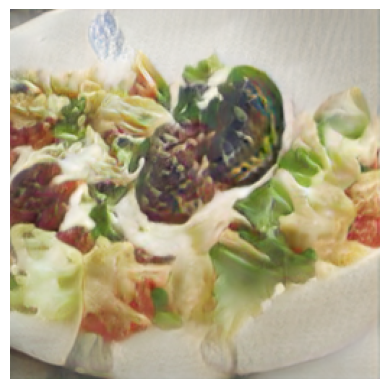

In [8]:
from common_new import get_title_wordvec, get_ingredients_wordvec, get_instructions_wordvec

def load_dict(file_path):
    with open(file_path, 'r') as f_vocab:
        w2i = {w.rstrip(): i+3 for i, w in enumerate(f_vocab)}
        w2i['<end>'] = 1
        w2i['<other>'] = 2
    return w2i

# load instructions word mapping file, used for model data preprocessing 
word2i = load_dict('/data/CS470_HnC/made_a_little_cookgan/vocab_inst.txt')

# load ingredients word mapping file, used for model data preprocessing 
ingr2i = load_dict('/data/CS470_HnC/made_a_little_cookgan/vocab_ingr.txt')

def vectorize(recipe, word2i, ingr2i):
    title, _ = get_title_wordvec(recipe, word2i) # np.int [max_len]
    ingredients, _ = get_ingredients_wordvec(recipe, ingr2i, permute_ingrs=False) # np.int [max_len]
    instructions, _, _ = get_instructions_wordvec(recipe, word2i) # np.int [max_len, max_len]
    return [torch.tensor(x).unsqueeze(0) for x in [title, ingredients, instructions]]
    
def generate_images(ingredients, batch) :
    title = 'dummy title'
    instructions = 'dummy instructions'

    recipe = {
        'title': title,
        'ingredients': [x.replace(' ', '_') for x in ingredients],
        'instructions': instructions
    }
    title_vec, ingrs_vec, insts_vec = vectorize(recipe, word2i, ingr2i)
    title_vec = title_vec.repeat(batch, 1)
    ingrs_vec = ingrs_vec.repeat(batch, 1)
    insts_vec = insts_vec.repeat(batch, 1, 1)
    noise = torch.FloatTensor(batch, 100).normal_(0, 1)
    text_feature = text_encoder([title_vec, ingrs_vec, insts_vec])
    
    imgs, _, _ = netG(noise, text_feature)
    img = imgs[2][0].detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    return img

img = generate_images(your_ingredient_list, 1) # without tomato
plt.axis('off') # 추가
plt.imshow(img)

In [9]:
import torch
from torch import nn
from torch.nn import functional as F
from datasets_retrieval import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import os
import sys
import math
import pdb
from copy import deepcopy
from glob import glob
from PIL import Image
import json
from common_new import load_recipes
from common_new import load_dict
from common_new import compute_img_feature, compute_txt_feature
import models_retrieval_nobak
import models_cookgan_for_retrieval

food_type = 'salad'
hot_ingr = your_main_ingredient
tops = 5

data_dir = '/data/CS470_HnC/made_a_little_cookgan/interpolation_example/data'
save_dir = '/data/CS470_HnC/made_a_little_cookgan/interpolation_save/'

if not os.path.exists(save_dir):
    print('create directory:', save_dir)
    os.makedirs(save_dir)

recipes = load_recipes(os.path.join(data_dir,'recipes.json'), 'val')
recipes = [x for x in recipes if food_type.lower() in x['title'].lower()]
vocab_inst = load_dict(os.path.join(data_dir, 'vocab_inst.txt'))
vocab_ingr = load_dict(os.path.join(data_dir, 'vocab_ingr.txt'))

for recipe in recipes:
    ingrediens_list = recipe['ingredients']
    recipe['new_ingrs'] = []
    for name in ingrediens_list:
        if hot_ingr in name:
            recipe['new_ingrs'].append(hot_ingr)
        else:
            recipe['new_ingrs'].append(name)

### Txtenc 받는 부분 수정
TxtEnc = models_retrieval_nobak.TextEncoder(
    data_dir='/data/CS470_HnC/made_a_little_cookgan/', text_info='010', hid_dim=300,
    emb_dim=300, z_dim=1024, with_attention=2,
    ingr_enc_type='rnn').eval()
TxtEnc.load_state_dict(torch.load('/data/CS470_HnC/made_a_little_cookgan/text_encoder.model'))
###

### Imgenc 받는 부분 수정
ImgEnc = models_retrieval_nobak.ImageEncoder(
        z_dim=1024).eval()
model = torch.load('/data/CS470_HnC/retrieval_model/wandb/run-20221115_141017-qn8zgvm8/files/00390000.ckpt')['image_encoder']
ImgEnc.load_state_dict(model, strict = False)
###

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

hot_recipes = [x for x in recipes if hot_ingr in x['new_ingrs']]
cold_recipes = [x for x in recipes if hot_ingr not in x['new_ingrs']]

recipes_a = []
recipes_b = []
threshold = 0.7
for rcp_a in hot_recipes:
    tmp = deepcopy(rcp_a['new_ingrs'])
    tmp.remove(hot_ingr)
    ingrs_a = set(tmp)
    for rcp_b in cold_recipes:
        ingrs_b = set(rcp_b['new_ingrs'])
        union = ingrs_a.union(ingrs_b)
        common = ingrs_a.intersection(ingrs_b)
        if 1.0*len(common)/len(union) >= threshold:
            recipes_a.append(rcp_a)
            recipes_b.append(rcp_b)

ids_a = set()
uniques_a = []
match = []
for rcp in recipes_a:
    if rcp['id'] not in ids_a:
        uniques_a.append(rcp)
        ids_a.add(rcp['id'])
        match.append(len(set(rcp['new_ingrs']).intersection(your_ingredient_list)))

ids_b = set()
uniques_b = []
for rcp in recipes_b:
    if rcp['id'] not in ids_b:
        uniques_b.append(rcp)
        ids_b.add(rcp['id'])

if len(uniques_a)>1 and len(uniques_b)>1:
    img_a, img_feat_a = compute_img_feature(uniques_a, ImgEnc)
    save_image(
        img_a[:64], 
        os.path.join(save_dir, '{}_with.jpg'.format(hot_ingr)), 
        normalize=True)
    img_feat_a = img_feat_a.detach().cpu().numpy()
    img_b, img_feat_b = compute_img_feature(uniques_b, ImgEnc)
    save_image(
        img_b[:64], 
        os.path.join(save_dir, '{}_without.jpg'.format(hot_ingr)),
        normalize=True)
    img_feat_b = img_feat_b.detach().cpu().numpy()
else:
    print('unable to compute')
    sys.exit(-1)

txt_feats = compute_txt_feature(recipes, TxtEnc, vocab_inst, vocab_ingr)
txt_feats = txt_feats.detach().cpu().numpy()

def compute_ingredient_retrival_score(imgs, txts, tops):
    imgs = imgs / np.linalg.norm(imgs, axis=1)[:, None]
    txts = txts / np.linalg.norm(txts, axis=1)[:, None]
    # retrieve recipe
    sims = np.dot(imgs, txts.T) # [N, N]
    # loop through the N similarities for images
    cvgs = []
    for ii in range(imgs.shape[0]):
        # get a row of similarities for image ii
        sim = sims[ii,:]
        # sort indices in descending order
        sorting = np.argsort(sim)[::-1].tolist()
        topk_idxs = sorting[:tops]
        success = 0.0
        for rcp_idx in topk_idxs:
            rcp = recipes[rcp_idx]
            ingrs = rcp['new_ingrs']
            if hot_ingr in ingrs:
                success += 1
        cvgs.append(success / tops)
    return np.array(cvgs)

cvgs = compute_ingredient_retrival_score(img_feat_a, txt_feats, tops)
cvgs = compute_ingredient_retrival_score(img_feat_b, txt_feats, tops)

netG = models_cookgan_for_retrieval.G_NET(levels=3).eval().requires_grad_(False)
netG.load_state_dict(torch.load('/data/CS470_HnC/made_a_little_cookgan/gen_salad_cycleTxt1.0_e300.model'))

with open(os.path.join(save_dir, '{}_with.json'.format(hot_ingr)), 'w') as f:
    json.dump(uniques_a, f, indent=2)
with open(os.path.join(save_dir, '{}_without.json'.format(hot_ingr)), 'w') as f:
    json.dump(uniques_b, f, indent=2)
N = min(len(uniques_a), len(uniques_b))
N = min(N, 128)
txt_feat_y = compute_txt_feature(uniques_a[:N], TxtEnc, vocab_inst, vocab_ingr)
txt_feat_n = compute_txt_feature(uniques_b[:N], TxtEnc, vocab_inst, vocab_ingr)

KeyboardInterrupt: 

In [ ]:
interpolate_points = [1.25, 1.0, 0.75, 0.5, 0.25, 0.0,-0.25]
print('interpolate points:', interpolate_points)
fixed_noise = torch.zeros(1, 100)
fixed_noise = fixed_noise.repeat(N, 1)

imgs_all = []
for w_y in interpolate_points:
    txt_embedding = w_y*txt_feat_y + (1-w_y)*txt_feat_n
    with torch.no_grad():
        fake_imgs, _, _ = netG(fixed_noise, txt_embedding)
    imgs = fake_imgs[-1] # those 256x256 images
    imgs_all.append(imgs[:30])
    imgs = imgs/2 + 0.5
    imgs = F.interpolate(imgs, [224, 224], mode='bilinear', align_corners=True)
    for i in range(imgs.shape[1]):
        imgs[:,i] = (imgs[:,i]-mean[i])/std[i]
    with torch.no_grad():
        img_feats = ImgEnc(imgs).detach().cpu().numpy()
    cvgs = compute_ingredient_retrival_score(img_feats, txt_feats, tops)

max_index = match.index(max(match))
save = imgs_all
save = torch.stack(save) 
save = save.permute(1,0,2,3,4).contiguous() 
save = save.view(-1, 3, 256, 256)
start = max_index * 7
end = start + 7
imgs_slice = save[start:end]
save_image(
    imgs_slice, 
    os.path.join(save_dir, '{}_interpolations.jpg'.format(hot_ingr)), 
    nrow=7, 
    normalize=True, 
    scale_each=True)

from IPython.display import Image
Image(filename='/data/CS470_HnC/made_a_little_cookgan/interpolation_save/{}_interpolations.jpg'.format(hot_ingr)) 

In [ ]:
# average serving of salad is about 75g.
# https://www.eatforhealth.gov.au/food-essentials/how-much-do-we-need-each-day/serve-sizes
interpolate_points = []
interpolate_points.append(your_main_ingredient_amount / 75)
print('interpolate point:', interpolate_points)
fixed_noise = torch.zeros(1, 100)
fixed_noise = fixed_noise.repeat(N, 1)

imgs_all = []
for w_y in interpolate_points:
    txt_embedding = w_y*txt_feat_y + (1-w_y)*txt_feat_n
    with torch.no_grad():
        fake_imgs, _, _ = netG(fixed_noise, txt_embedding)
    imgs = fake_imgs[-1] # those 256x256 images
    imgs_all.append(imgs[:30])
    imgs = imgs/2 + 0.5
    imgs = F.interpolate(imgs, [224, 224], mode='bilinear', align_corners=True)
    for i in range(imgs.shape[1]):
        imgs[:,i] = (imgs[:,i]-mean[i])/std[i]
    with torch.no_grad():
        img_feats = ImgEnc(imgs).detach().cpu().numpy()
    cvgs = compute_ingredient_retrival_score(img_feats, txt_feats, tops)

max_index = match.index(max(match))
save = imgs_all
save = torch.stack(save) 
save = save.permute(1,0,2,3,4).contiguous() 
save = save.view(-1, 3, 256, 256)
start = max_index
imgs_slice = save[max_index]
save_image(
    imgs_slice, 
    os.path.join(save_dir, '{}_interpolations_actual.jpg'.format(hot_ingr)), 
    nrow=7, 
    normalize=True, 
    scale_each=True)

from IPython.display import Image
Image(filename='/data/CS470_HnC/made_a_little_cookgan/interpolation_save/{}_interpolations_actual.jpg'.format(hot_ingr)) 

KeyboardInterrupt: 